<a id='table_of_contents'></a>

0. [Import libraries](#imports)
1. [Import data](#import_data)
2. [Data exploration](#data_exploration)
3. [Data cleaning](#data_cleaning)
4. [Data preparation](#data_preparation)
5. [Benchmark model](#benchmark_model)<br>
6. [Feature engineering](#feature_engineering)
7. [Model training](#model_training)<br>
    7.1. [Decision Tree](#decision_tree)<br>
    7.2. [Random Forest](#random_forest)<br>
    7.3. [Comparing algorithm performances](#comparing_algorithm_performances)
8. [Tuning](#tuning)<br>

# 0. Import libraries <a id='imports'></a>

[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import data <a id='import_data'></a>
[Back to top](#table_of_contents)

In [2]:
taxi_data_jan_2025 = pd.read_parquet(r'data/yellow_tripdata_2020-01.parquet',engine='pyarrow')
taxi_df = pd.concat([taxi_data_jan_2025])

In [3]:
print(taxi_df.shape)
taxi_df.head()

(6405008, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


# 2. Data exploration <a id='data_exploration'></a>
[Back to top](#table_of_contents)

In [4]:
taxi_df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [5]:
taxi_df.shape

(6405008, 19)

In [6]:
taxi_df = taxi_df[['tpep_pickup_datetime', 'tpep_dropoff_datetime','passenger_count',
                   'trip_distance', 'RatecodeID','PULocationID', 'DOLocationID',
                   'payment_type', 'total_amount']]

In [7]:
taxi_df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,238,239,1,11.27
1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,239,238,1,12.30
2,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,238,238,1,10.80
3,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,238,151,1,8.16
4,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,193,193,2,4.80


array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

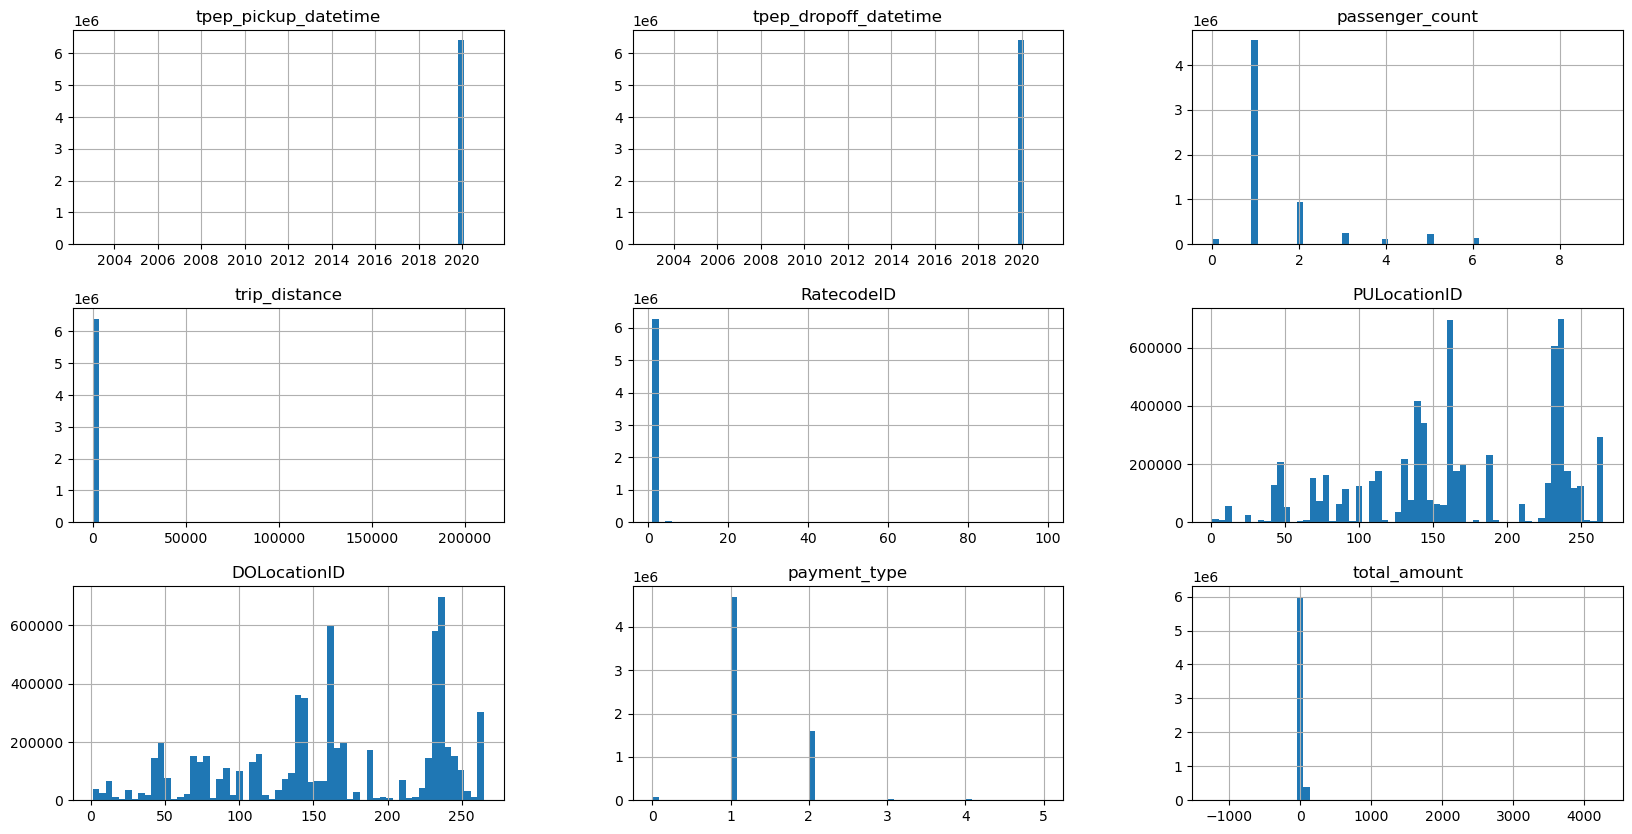

In [8]:
taxi_df.hist(figsize=(20,10),bins=60)

payment_type
4    8844
3    6985
2    3593
0      64
1      19
Name: count, dtype: int64


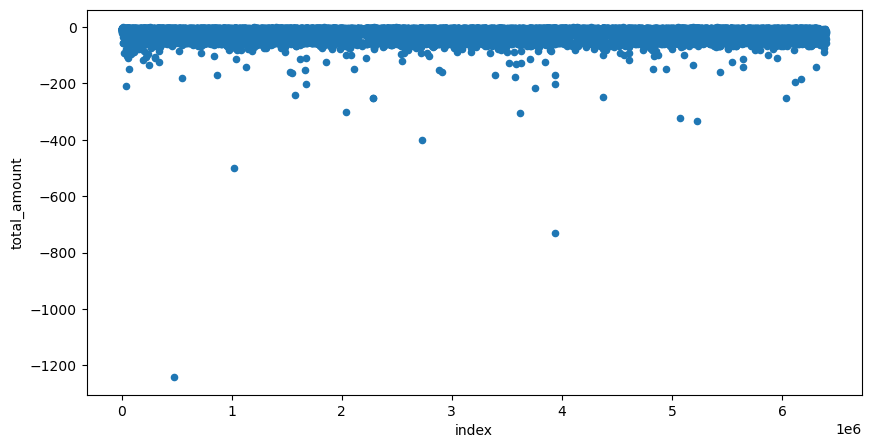

In [9]:
taxi_df[taxi_df['total_amount']<0].reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5))
print(taxi_df[taxi_df['total_amount']<0]['payment_type'].value_counts())

We can safely ignore negative amounts as we can see most of it are disputes(payment type 4) or payment with cash.
Zero values can also be ignored because most of those have a trip distance of 0(meaning it's the result of canceled trips)

trip_distance
0.00    1044
0.01      37
0.02      19
0.10      16
0.03      14
        ... 
3.34       1
9.71       1
9.54       1
3.40       1
1.09       1
Name: count, Length: 356, dtype: int64


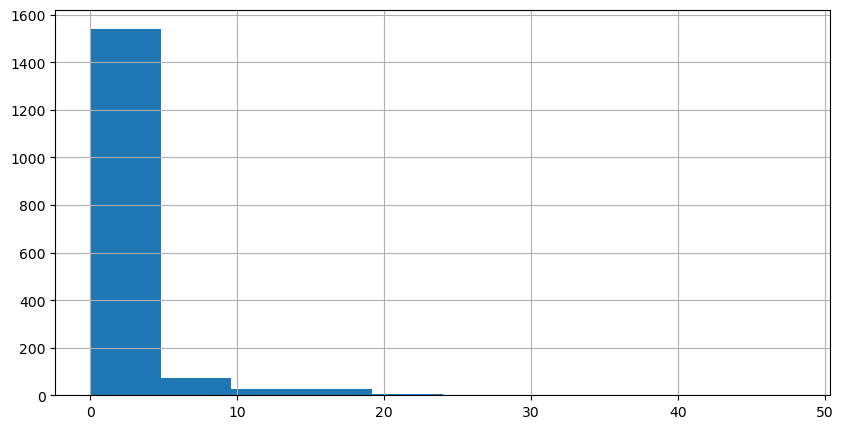

In [10]:
taxi_df[taxi_df['total_amount']==0]['trip_distance'].hist(figsize=(10,5),bins=10)
print(taxi_df[taxi_df['total_amount']==0]['trip_distance'].value_counts())

In [11]:
taxi_df[taxi_df['total_amount']>200].shape

(1197, 9)

As we can see, out of the 3475226 entries we have 1913 entries with a total amount that is more than 200 dollars, so we can say those are outliers and shouldn't weight in our research

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

<Axes: xlabel='index', ylabel='total_amount'>

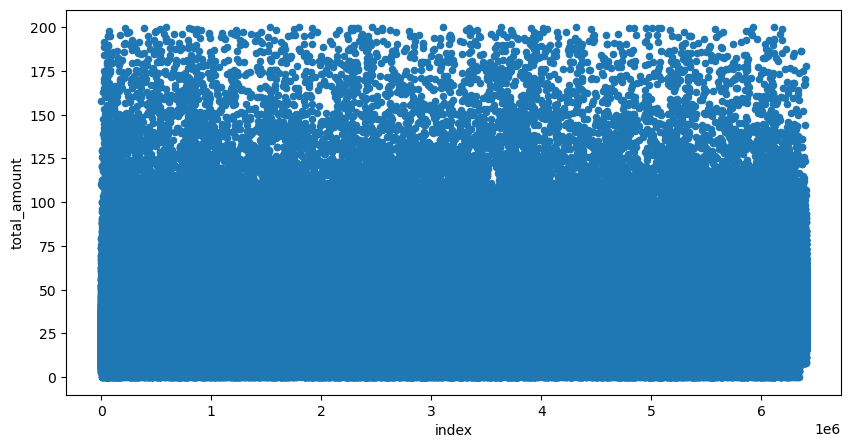

In [13]:
taxi_df.reset_index().plot(kind='scatter',y='total_amount',x='index',figsize=(10,5))

In [14]:
max_amount = taxi_df['total_amount'].max()
print(max_amount)

200.0


In [15]:
taxi_df.isna().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          65377
trip_distance                0
RatecodeID               65377
PULocationID                 0
DOLocationID                 0
payment_type                 0
total_amount                 0
dtype: int64

In [16]:
taxi_df.passenger_count.value_counts(dropna=False)

passenger_count
1.0    4530467
2.0     943042
3.0     249380
5.0     225167
6.0     131930
4.0     122967
0.0     114239
NaN      65377
7.0         29
9.0         19
8.0         17
Name: count, dtype: int64

there is very few data with NaN values, it should be an error while reading the parquet, but as for now i can't find the answer so we avoid that data.

In [23]:
taxi_df.dropna(inplace=True)

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

In [18]:
taxi_df.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
total_amount                    float64
dtype: object

In [27]:
taxi_df_prepared =taxi_df.copy()

In [29]:
taxi_df_prepared.loc[:,'RatecodeID']= taxi_df_prepared['RatecodeID'].astype(str)
taxi_df_prepared.loc[:,'payment_type']= taxi_df_prepared['payment_type'].astype(str)
taxi_df_prepared.loc[:,'PULocationID']= taxi_df_prepared['PULocationID'].astype(str)
taxi_df_prepared.loc[:,'DOLocationID']= taxi_df_prepared['DOLocationID'].astype(str)
taxi_df_prepared.loc[:,'passenger_count']=taxi_df_prepared['passenger_count'].astype('int64')

In [21]:
taxi_df_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,238,239,1,11.27
1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,239,238,1,12.30
2,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,238,238,1,10.80
3,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,238,151,1,8.16
4,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,193,193,2,4.80


In [31]:
taxi_df_prepared['transaction_date'] = pd.to_datetime(taxi_df_prepared['tpep_pickup_datetime'].dt.date)
taxi_df_prepared['transaction_year'] = taxi_df_prepared['tpep_pickup_datetime'].dt.year
taxi_df_prepared['transaction_month'] = taxi_df_prepared['tpep_pickup_datetime'].dt.month
taxi_df_prepared['transaction_day'] = taxi_df_prepared['tpep_pickup_datetime'].dt.day
taxi_df_prepared['transaction_hour'] = taxi_df_prepared['tpep_pickup_datetime'].dt.hour

In [32]:
taxi_df_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
transaction_date         datetime64[ns]
transaction_year                  int32
transaction_month                 int32
transaction_day                   int32
transaction_hour                  int32
dtype: object

In [33]:
taxi_df_prepared.transaction_year.value_counts()

transaction_year
2020    6317096
2019        129
2009         19
2008         10
2021          3
Name: count, dtype: int64

While preparing the data we discovered that there must be some error in the dates, this dataset is for january of 2020, there can't be values other than 2020 so we have to clean it.

In [34]:
taxi_df_prepared = taxi_df_prepared[taxi_df_prepared['transaction_year']==2020]
taxi_df_prepared = taxi_df_prepared[taxi_df_prepared['transaction_month']==1]

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

## 7.1. Decision tree <a id='decision_tree'></a>

## 7.2. Random forest <a id='random_forest'></a>

## 7.3. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)